# fMRI visualization with nilearn


@author : Romy BEAUTÉ

@date : 02/06/2022

### Ressources : 
- Plotting tools in nilearn : https://nilearn.github.io/auto_examples/01_plotting/plot_demo_plotting.html#sphx-glr-auto-examples-01-plotting-plot-demo-plotting-py
- Input and output: neuroimaging data representation : http://nilearn.github.io/manipulating_images/input_output.html
- nilearn.plotting.plot_anat : https://nilearn.github.io/modules/generated/nilearn.plotting.plot_anat.html#nilearn.plotting.plot_anat

- Nibabel images : https://nipy.org/nibabel/nibabel_images.html
- Images and memory : https://nipy.org/nibabel/images_and_memory.html#using-uncache
- Read and visualize structutal MRI data : https://neuraldatascience.io/8-mri/read_viz.html

- pydicom : https://github.com/pydicom/pydicom/tree/master/examples

In [49]:
# Import modules & select visualization specs

import numpy as np
import matplotlib.pyplot as plt
import os
from os import path

import nilearn
import dicom2nifti
import nibabel as nib
import scipy.ndimage as ndi
from nilearn import plotting
from nilearn.image.image import mean_img
from nilearn.plotting import plot_epi, show

import imageio as iio


#### Enter variables of images we want to open ####
id_subject = "01" 
orga_type = "DICOM" #can be "DICOM" or "BIDS"
modality = "t2star" #chosen fMRI modality


#### Pre-defined paths ####
data_folder = "/mnt/data/romy/hypnomed/MRI_raw/{}".format(orga_type)
project_directory = "~/projects"

In [50]:
#Import fMRI image we want to visualize
def path_to_scans(id_subject,data_folder,modality):

    """
    Return the path of the MRI file for selected subject & modalities
    """

    path_list = list()
    data_path = os.path.join(data_folder,"sub-{}/ses-001".format(id_subject))
    scans = [scans for scans in (os.listdir(data_path)) if modality in scans] #select scans for specific type 
    
    for _,scan in enumerate(scans):
        path_list.append(os.path.join(data_path,scan)) #add path of each scan in a list
    
    return path_list




def dicom_to_nifti(dicom_directory):
    """
    - Create NIFTI folder to convert DICOM data 
    - Create + return a nibabel image object
    """

    nifti_folder = os.path.join(dicom_directory,"nifti") #Create Nifti folders to store converted DICOM
    if not os.path.isdir(nifti_folder): 
        os.makedirs(nifti_folder)
        print("Created following nifti directory : ",nifti_folder)

    if len(nifti_folder)==0: #if nifty folder empty
        dicom2nifti.convert_directory(
            dicom_directory = dicom_directory,
            output_folder = nifti_folder, 
            compression=True, reorient=True)
        print('Successfully converted DICOM data in nifti')

    nifti_path = os.path.join(dicom_directory,nifti_folder)
    nifti_img = os.listdir(nifti_path)[0]

    return nib.load(os.path.join(nifti_path,nifti_img)) #nifti_img


In [51]:
path_imgs = path_to_scans(id_subject,data_folder,modality) #get list of paths for images of interest (specific subject and modalities)
print("2 {} images for sub-{}".format(modality,id_subject))

for _,path_img in enumerate(path_imgs):
    if orga_type == "DICOM":
        img = dicom_to_nifti(dicom_directory=path_img) #get #nifti_img object (type = nibabel.nifti1.Nifti1Image)
        print(type(img))
    if len(img.shape)==4:
        img = nilearn.image.mean_img(img) #reshape nifti in 3D

    # plotting.plot_img(img,title=path_img)
    # plotting.plot_anat(img,title="plot_anat")
    # plot_epi(img,title="plot_epi")
    

2 t2star images for sub-01
<class 'nibabel.nifti1.Nifti1Image'>
<class 'nibabel.nifti1.Nifti1Image'>


## Visualize a series of slices

Ref : https://neuraldatascience.io/8-mri/nifti.html

Created <class 'numpy.ndarray'> nifti object of shape (128, 108, 80)


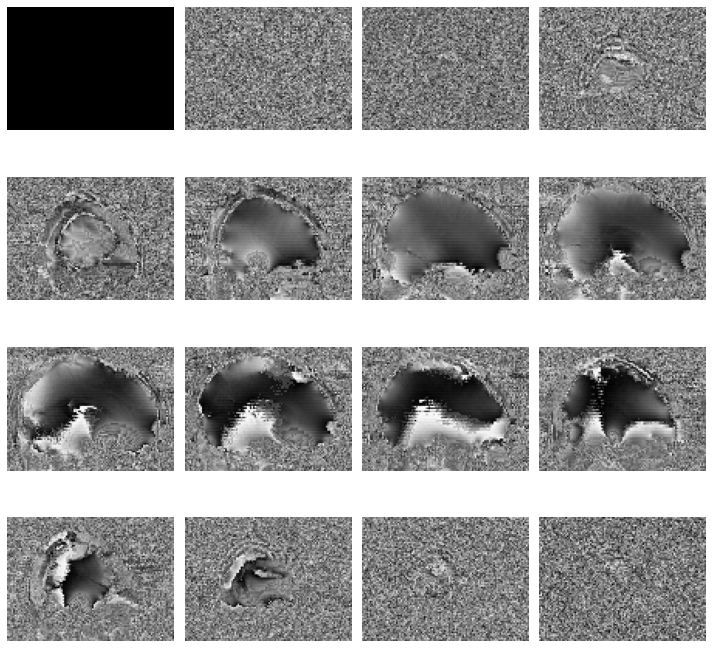

In [52]:
brain_vol_data = img.get_fdata() #get data in numpy array
print("Created {} nifti object of shape {}".format(type(brain_vol_data),brain_vol_data.shape))

fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[img, :, :], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()


In [53]:
import pydicom
import difflib

from pydicom.data import get_testdata_file
from pydicom import dcmread

anat_t2star = path_to_scans(id_subject,data_folder,"t2star") # T2* doit servir à construire une carte de champs de distorsion 

scan1 = anat_t2star[0]
scan2 = anat_t2star[1]

print(scan1)
print(scan2)



print('Nomber of files in {} : {}'.format(scan1,len(os.listdir(scan1))))
print('Nomber of files in {} : {}'.format(scan2,len(os.listdir(scan2))))





/mnt/data/romy/hypnomed/MRI_raw/DICOM/sub-01/ses-001/12_anat_t2star_2iso
/mnt/data/romy/hypnomed/MRI_raw/DICOM/sub-01/ses-001/13_anat_t2star_2iso
Nomber of files in /mnt/data/romy/hypnomed/MRI_raw/DICOM/sub-01/ses-001/12_anat_t2star_2iso : 401
Nomber of files in /mnt/data/romy/hypnomed/MRI_raw/DICOM/sub-01/ses-001/13_anat_t2star_2iso : 401


In [60]:
fpath1 = os.path.join(scan1,os.listdir(scan1)[0]) #take the first dcm file of scan1
fpath2 = os.path.join(scan2,os.listdir(scan2)[0]) #take the first dcm file of scan2



ds1 = dcmread(fpath1)
ds2 = dcmread(fpath2)



#Print infos for the 2 files corresponding to "echo" and "epi" informations


print(70*'-')
print('Echo informations')
print(70*'-')
for _,(info1,info2) in enumerate(zip(ds1.dir("echo"),ds2.dir("echo"))):
    print('*******')
    print("{} file 1 : {}".format(info1,ds1[info1]))
    print("{} file 2 : {}".format(info2,ds2[info2]))
    
print(70*'-')
print('EPI informations')
print(70*'-')
for _,(info1,info2) in enumerate(zip(ds1.dir("epi"),ds2.dir("epi"))):
    print('*******')
    print("{} file 1 : {}".format(info1,ds1[info1]))
    print("{} file 2 : {}".format(info2,ds2[info2]))

print(70*'-')
print('PHASE informations')
print(70*'-')
for _,(info1,info2) in enumerate(zip(ds1.dir("phase"),ds2.dir("phase"))):
    print('*******')
    print("{} file 1 : {}".format(info1,ds1[info1]))
    print("{} file 2 : {}".format(info2,ds2[info2]))




----------------------------------------------------------------------
Echo informations
----------------------------------------------------------------------
*******
EchoNumbers file 1 : (0018, 0086) Echo Number(s)                      IS: '4'
EchoNumbers file 2 : (0018, 0086) Echo Number(s)                      IS: '5'
*******
EchoTime file 1 : (0018, 0081) Echo Time                           DS: '20.0'
EchoTime file 2 : (0018, 0081) Echo Time                           DS: '30.0'
*******
EchoTrainLength file 1 : (0018, 0091) Echo Train Length                   IS: '5'
EchoTrainLength file 2 : (0018, 0091) Echo Train Length                   IS: '5'
----------------------------------------------------------------------
EPI informations
----------------------------------------------------------------------
*******
LargestImagePixelValue file 1 : (0028, 0107) Largest Image Pixel Value           US: 2579
LargestImagePixelValue file 2 : (0028, 0107) Largest Image Pixel Value           US

# Find the differences between the two DICOM files we want to compare 

In [61]:
print(__doc__)

datasets = tuple([pydicom.dcmread(filename, force=True)
                  for filename in (fpath1,fpath2)])

# difflib compare functions require a list of lines, each terminated with
# newline character massage the string representation of each dicom dataset
# into this form:

rep = []
for dataset in datasets:
    lines = str(dataset).split("\n")
    lines = [line + "\n" for line in lines]  # add the newline to end
    rep.append(lines)

diff = difflib.Differ()
for line in diff.compare(rep[0], rep[1]): # write line if different for the two files
    if line[0] != "?":
        print(line)

Automatically created module for IPython interactive environment
  Dataset.file_meta -------------------------------

  (0002, 0000) File Meta Information Group Length  UL: 194

  (0002, 0001) File Meta Information Version       OB: b'\x00\x01'

  (0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage

- (0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.2.43.66012.2018060412072750175817833

+ (0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.2.43.66012.2018060412072755812217850

  (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian

  (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1

  (0002, 0013) Implementation Version Name         SH: 'dcm4che-2.0'

  (0002, 0016) Source Application Entity Title     AE: 'PRISMA'

  -------------------------------------------------

  (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'

- (0008, 0008) Image Type                          C

### BONUS : print infos contained in the two files if need to use later

In [62]:
print(ds1)
print(ds2)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.2.43.66012.2018060412072750175817833
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-2.0'
(0002, 0016) Source Application Entity Title     AE: 'PRISMA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM']
(0008, 0012) Instance Creation Date              DA: '20180604'
(0008, 0013) Instance Creation Time              TM: '120732.185000'
(0008, 0016) SOP Class UID    